<a href="https://colab.research.google.com/github/LucaMagini/AgeDetection/blob/main/1Data_Cleaning%26Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AGE DETECTION

**Age detection** plays an important role in many different scenarios, including customer profiling, security and defense applications or intelligent video surveillance.  
Estimating the age based on a face image is a difficult task because facial variation is specific to a given individual person and can be influenced by external factors as climate or lifestyle.
<br />
<br />
In this project we'll try to build a model to estimate the age by performing supervised age range estimation using Convolutional Neural Networks (**CNN**) for a multi class classification task.  
**CNN** are a subtype of the Neural Networks and they are mainly used for image and speech recognition, they emerged from the study of the brain's visual cortex, and they have been used in image recognition since the 1980s.  
In the last few years, thanks to the increase in computational power and the amount of available training data, **CNN**s have managed to achieve superhuman performance on some complex visual tasks.  
<br />
I have choosen the following age ranges:  

| Age Range | Class |
| :---: | :-----------: |
| 0-9 | 0 |
| 10-19 | 1 |
| 20-29 | 2 |
| 30-39 | 3 |
| 40-49 | 4 |
| 50-59 | 5 |
| 60-69 | 6 |
| 70+ | 7 |


<br />

In general trying different age groups can be a good attempt to improve the model performance, but in this case I want to force these specific ranges and find a good model on these.


## Dataset



We'll use 2 different facial images datasets: 
  * [Kaggle Dataset](https://www.kaggle.com/datasets/frabbisw/facial-age)
  * [UTK Dataset](https://susanqq.github.io/UTKFace/)

<br />

The **Kaggle dataset** is very simple and easy to use. There are 99 folders where each folder's label represents the age of corresponding images inside the folder. All images are in PNG format and every image covers only the face of a human body.  
<br />

The **UTK dataset** is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images (JPG format) with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc.  
The labels of each face image is embedded in the file name, formatted like "age_gender_race_date&time.jpg"

## Data Cleaning & Preparation

In [ ]:
#Importing the libraries
import os, re, random, shutil, glob, cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from zipfile import ZipFile
from PIL import Image 
from imageio import imread 

In [ ]:
#Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Unzipping the Kaggle Dataset
facial_age_zip_path = "/content/drive/MyDrive/Age_Detection_Project/Data/KaggleFacialAge.zip"

with ZipFile(facial_age_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping KaggleFacialAge.zip')

Done unzipping KaggleFacialAge.zip


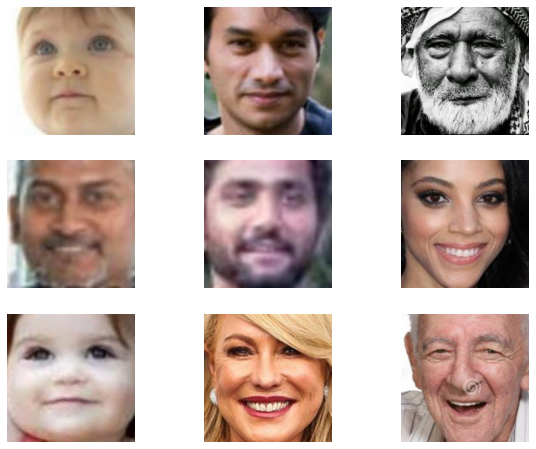

In [ ]:
#Showing some random Kaggle dataset images
kaggle_folder = '../content/KaggleFacialAge'

images = []
for folder in os.listdir(kaggle_folder):
  for image in os.listdir(kaggle_folder + '/' + folder):
    images.append(os.path.join(kaggle_folder, folder, image))

plt.figure(1, figsize=(10, 8))
plt.axis('off')
n = 0
for i in range(9):
  n += 1
  random_img = random.choice(images)
  imgs = imread(random_img)
  plt.subplot(3, 3, n)
  plt.axis('off')
  plt.imshow(imgs)

plt.show()

In [ ]:
#Creating an array of all the folders name of the dataset
kaggle_faces_path = "../content/KaggleFacialAge"
kaggle_faces_folders = os.listdir(kaggle_faces_path)
kaggle_faces_folders = np.array(kaggle_faces_folders)

#Creating Dictionary Containing Number of Images per Age for Kaggle Dataset
kaggle_images = {}

for folder in kaggle_faces_folders:
    temp_path = os.path.join(kaggle_faces_path, folder)
    n_images = len(os.listdir(temp_path))
    kaggle_images[int(folder)] = n_images   

In [ ]:
#Unzipping the UTK Dataset
facial_age_zip_path = "/content/drive/MyDrive/Age_Detection_Project/Data/UTKFaces.zip"

with ZipFile(facial_age_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping UTKFaces.zip')

Done unzipping UTKFaces.zip


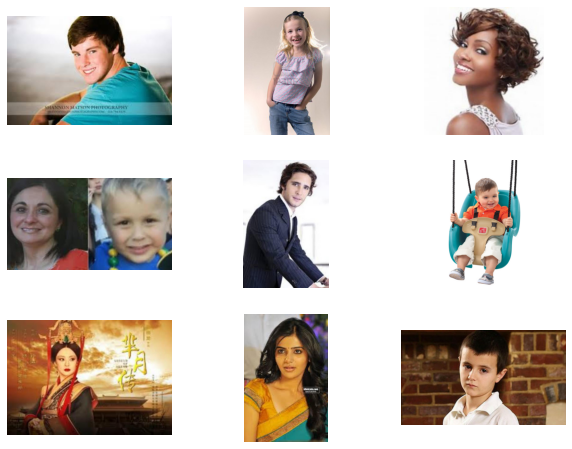

In [ ]:
#Showing some random UTK dataset images
utk_folder = '../content/UTKFaces'

images = []
for image in os.listdir(utk_folder):
    images.append(os.path.join(utk_folder, image))

plt.figure(1, figsize=(10, 8))
plt.axis('off')
n = 0
for i in range(9):
  n += 1
  random_img = random.choice(images)
  imgs = imread(random_img)
  plt.subplot(3, 3, n)
  plt.axis('off')
  plt.imshow(imgs)

plt.show()

In [ ]:
#Creating a dictionary containing the number of images per age for UTK dataset
utk_images = {}
utk_faces_path = "../content/UTKFaces"
utkface_image_names = os.listdir(utk_faces_path)

#Function for finding age from image 
def finding_age(image_name):
    image_labels = image_name.split('_')
    age = int(image_labels[0])
    return age

for image in utkface_image_names:
    age = finding_age(image)
    if age not in utk_images:
        utk_images[age] = 1
    else:
        utk_images[age] += 1

#Sorting the dict
utk_images = dict(sorted(utk_images.items(), key=lambda x: x[0]))

In [ ]:
#Merging the dictionaries 
def mergeDict(dict_1, dict_2):
    merged_dict = {**dict_1, **dict_2}
    for key, value in merged_dict.items():
        if key in dict_1 and key in dict_2:
            merged_dict[key] = dict_1[key] + dict_2[key]
    return merged_dict        

#Merging the kaggle & utk dictionaries and sorting the new dict
combined_images = mergeDict(kaggle_images , utk_images)
combined_images = dict(sorted(combined_images.items(), key=lambda x: x[0])) 

In [ ]:
#Showing the total number of images
total_img = 0
for k, v in combined_images.items():
    total_img += v
    
print('Total number of images: {}'.format(total_img))

Total number of images: 33884


In [ ]:
#Function for dividing images in defined groups 
def defined_groups(diz, *age_ranges):
  index = 0
  groups = []
  range = []
  for k, v in diz.items():
      if index + 1 > len(age_ranges) or k <= age_ranges[index]:
          range.append(k)
      else:
          groups.append(range)
          range = [k]
          index += 1
  groups.append(range)

  return groups   

#Dividing images into defined age ranges
grs = defined_groups(combined_images, 9, 19, 29, 39, 49, 59, 69)   

In [ ]:
#Creating list containing class info
def info_ranges(grs):
    res = []

    for index, value in enumerate(grs):
        temp = 0
        for num in value:
            temp += combined_images[num]
        res.append([index, str(value[0])+'-'+str(value[-1]), temp, str(round(temp/total_img*100,3)) + '%'])

    return res

#Creating list from defined age ranges
res = info_ranges(grs)
print('--- CLASS INFO ---')
for elem in res:
  print(elem)   

--- CLASS INFO ---
[0, '1-9', 6280, '18.534%']
[1, '10-19', 2773, '8.184%']
[2, '20-29', 8883, '26.216%']
[3, '30-39', 5579, '16.465%']
[4, '40-49', 2923, '8.626%']
[5, '50-59', 3247, '9.583%']
[6, '60-69', 1991, '5.876%']
[7, '70-116', 2208, '6.516%']


In [ ]:
#Transforming list in dataframe and showing it 
df = pd.DataFrame(res, columns = ['Label', 'Age-Range', '#Images', '%Total']) 
print(df)

   Label Age-Range  #Images   %Total
0      0       1-9     6280  18.534%
1      1     10-19     2773   8.184%
2      2     20-29     8883  26.216%
3      3     30-39     5579  16.465%
4      4     40-49     2923   8.626%
5      5     50-59     3247   9.583%
6      6     60-69     1991   5.876%
7      7    70-116     2208   6.516%


In [ ]:
#Putting images in one folder fixing images name

#Creating the folder
comb_path = "../content/Combined_Images"
if not os.path.exists(comb_path):
    os.makedirs(comb_path)

#Copying images of UTK dataset
src_dir = utk_faces_path
counter = 0
print('--- Copying UTK dataset images into combined images folder ---\n')
for jpgfile in glob.iglob(os.path.join(src_dir, "*.jpg")):
    shutil.copy(jpgfile, comb_path)

    counter += 1
    if counter % 3000 == 0:
        print('Images copied to combined images folder = {} of 33884'.format(counter)) 

--- Copying UTK dataset images into combined images folder ---

Images copied to combined images folder = 3000 of 33884
Images copied to combined images folder = 6000 of 33884
Images copied to combined images folder = 9000 of 33884
Images copied to combined images folder = 12000 of 33884
Images copied to combined images folder = 15000 of 33884
Images copied to combined images folder = 18000 of 33884
Images copied to combined images folder = 21000 of 33884
Images copied to combined images folder = 24000 of 33884


In [ ]:
#Copying images of Kaggle dataset
src_dir = kaggle_faces_path
print('--- Copying Kaggle dataset images into combined images folder ---\n')
for folder in os.listdir(kaggle_faces_path):
    for pngfile in glob.iglob(os.path.join(src_dir + '/' + folder, "*.png")):
        pngfile_id = pngfile.split("/")[-1]
        destpath = comb_path + '/' + str(int(folder)) + '_' + pngfile_id[:-4] + '.jpg'

        #Loading .png image
        png_img = cv2.imread(pngfile)
        
        #Converting to jpg file and saving
        cv2.imwrite(destpath, png_img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
        
        counter += 1
        if counter % 3000 == 0:
            print('Images copied to combined images folder = {} of 33884'.format(counter))
        
print('Images copied to combined images folder = {} of 33884'.format(counter))

--- Copying Kaggle dataset images into combined images folder ---

Images copied to combined images folder = 27000 of 33884
Images copied to combined images folder = 30000 of 33884
Images copied to combined images folder = 33000 of 33884
Images copied to combined images folder = 33884 of 33884


In [ ]:
#Function to get the label from the age 
def label_map(age, res):  
    age = int(age)
    if age >=int(res[0][1].split('-')[0]) and age <=int(res[0][1].split('-')[1]):
        return 0
    elif age >=int(res[1][1].split('-')[0]) and age <=int(res[1][1].split('-')[1]):
        return 1
    elif age >=int(res[2][1].split('-')[0]) and age <=int(res[2][1].split('-')[1]):
        return 2
    elif age >=int(res[3][1].split('-')[0]) and age <=int(res[3][1].split('-')[1]):
        return 3
    elif age >=int(res[4][1].split('-')[0]) and age <=int(res[4][1].split('-')[1]):
        return 4
    elif age >=int(res[5][1].split('-')[0]) and age <=int(res[5][1].split('-')[1]):
        return 5
    elif age >=int(res[6][1].split('-')[0]) and age <=int(res[6][1].split('-')[1]):
        return 6
    elif age >=int(res[7][1].split('-')[0]) and age <=int(res[7][1].split('-')[1]):
        return 7    
    else:
        return 'Age out of bound!'

In [ ]:
#Creating the list with all info for each image
result = []
for image in os.listdir(comb_path):
    age = int(image.split('_')[0])
    label = label_map(age, res)
    result.append([image, age, label])
    
#Trasforming the res list in a dataframe
data = pd.DataFrame(result, columns =['FileName', 'Age', 'Label'])  
print(data) 

                           FileName  Age  Label
0      25_0_3_20170104214610101.jpg   25      2
1                       34_9722.jpg   34      3
2                       31_1484.jpg   31      3
3                       26_9509.jpg   26      2
4      21_0_2_20170116170907317.jpg   21      2
...                             ...  ...    ...
33879  42_0_2_20170112215219256.jpg   42      4
33880  27_0_0_20170117175356352.jpg   27      2
33881  37_1_1_20170116160528038.jpg   37      3
33882  11_1_0_20170109204611305.jpg   11      1
33883                    1_8935.jpg    1      0

[33884 rows x 3 columns]


In [ ]:
#Function to get the label from the image name
def get_label(filename, res):
    age = filename.split('_')[0]
    return str(label_map(age, res))

In [ ]:
#Dividing the combined image folder into two folders for training (70%) , validation (15%) and testing (15%) datasets
img_names = data['FileName'].tolist()
random.seed(41)
random.shuffle(img_names)

def partition_pct(lst, point1, point2):
    index1 = int(len(lst) * point1)
    index2 = int(len(lst) * (point1 + point2))
    return lst[:index1], lst[index1:index2], lst[index2:]

train, dev, test = partition_pct(img_names, .7, .15)

In [ ]:
#Creating subfolders divided for labels to use the tensorflow function that get the label from the subfolder's name

#Creating the folders
train_path = "../content/Train"
dev_path = "../content/Dev"
test_path = "../content/Test"

#Creating the train folder
if not os.path.exists(train_path):
    os.makedirs(train_path)
for image in train:
    if not os.path.exists(os.path.join(train_path, get_label(image, res))):      
        os.makedirs(os.path.join(train_path,get_label(image, res)))  
    shutil.copy(os.path.join(comb_path,image),os.path.join(train_path, get_label(image, res),image))

In [ ]:
#Creating dev folder
if not os.path.exists(dev_path):
    os.makedirs(dev_path)
for image in dev:
    if not os.path.exists(os.path.join(dev_path, get_label(image, res))):      
        os.makedirs(os.path.join(dev_path,get_label(image, res)))  
    shutil.copy(os.path.join(comb_path,image),os.path.join(dev_path, get_label(image, res),image))

In [ ]:
#Creating test folder
if not os.path.exists(test_path):
    os.makedirs(test_path)
for image in test:
    if not os.path.exists(os.path.join(test_path, get_label(image, res))):      
        os.makedirs(os.path.join(test_path,get_label(image, res)))  
    shutil.copy(os.path.join(comb_path,image),os.path.join(test_path, get_label(image, res),image))

In [ ]:
#Creating the folders Train.zip and Dev_Test.zip and saving them on the Google Drive
train_filename = '../content/drive/MyDrive/Age_Detection_Project/Data/Train'
dev_filename = '../content/drive/MyDrive/Age_Detection_Project/Data/Dev'
test_filename = '../content/drive/MyDrive/Age_Detection_Project/Data/Test'
shutil.make_archive(train_filename, 'zip', train_path)
shutil.make_archive(dev_filename, 'zip', dev_path)
shutil.make_archive(test_filename, 'zip', test_path)

'/content/drive/MyDrive/Age_Detection_Project/Data/Test.zip'

### Talking about Class Imbalance problem

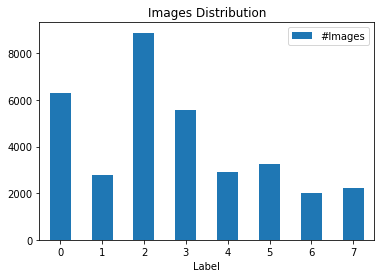

In [ ]:
#Showing data distribution
df.plot(x ='Label', y='#Images', kind ='bar', rot=0, title='Images Distribution')
plt.show()

**Class imbalance** is a widely encountered problem in the machine learning community, specifically in computer vision, where there exist different number of images for each of your class in your dataset. In real applications, **class imbalance** is by far the most common scenario.  

There are some different techniques to fix this kind of problem:
  * **Resampling**
    * **Undersampling**
    * **Oversampling**
    * **Ensembling**

*Undersampling* --  is a technique to balance uneven datasets by keeping all of the data in the minority class and decreasing the size of the majority class.  
*Oversampling* --  is basically the opposite of undersampling, it consists of increasing the number of elements of the minority class. One of the most popular algorithm for oversampling is the Synthetic Minority Oversampling Technique (SMOTE).
*Ensembling* -- is a mix of the previous methods.  

<br />

  * **Merging Similar Classes** 

This method is clearly only useful on a multiclass-classification problem.  
This strategy takes a lot of domain knowledge in order to make such a decision, depending on the case, it might be wise to consult an expert in the field or analyzing the end goal of the project before merging any classes together.

<br />

  * **Data Augmentation**  

It's technique used to increase the amount of data by adding slightly modified copiues of already existing data or newly created synthetic data from existing data.  
It's advisable not to use this method if the difference between classes is huge.  

<br />

  * **GANs for generating new data**

It's a way of generating completely new data, GANs are able to generate high quality human-proof images, but this will require a large amount of computing resources.

<br />

  * **Change the perfomance metric**

Accuracy is not the best metrci to use when to evaluate heavily imbalanced datasets as it can be misleading. It can be used other different metrics as Confusion Matrix, Precision, Recall or F1-Score.


### Choice in our case

Anyway in general it's hard to generalize when there is too few of a certain class samples especially with lots of dimensions.  
There isn't a general rule, and we have to evaluate case by case, the techniques to avoid imbalanced data could even not work at all.  
<br />
It's a hot topic in the ML community, and it seems to be much less of a problem than is often suggested and most of the apparent issues come from using improper scoring rules.  
<br />
In this case, class distributions doesn't seem that bad. I've tried some of the techniques to avoid imbalanced data without too much success, the models seem to generalize alright with enough samples regardless of the class ratio.  
So I'll not resample at all but I'll use accuracy as standard metric but I will evaluate the confusion matrix with the related metrics: precision, recall and F1-score.  
<br />
In the next notebook I'll perform data augmentation not for address a data imbalanced problem but to have a more robust training dataset.
